Copyright (C) 2024  Adam Jones  All Rights Reserved

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
import figure_standard
import h5py as h5
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from matplotlib.transforms import blended_transform_factory
import os

In [2]:
figure_standard.standardize_plot_settings()
main_palette = figure_standard.create_main_palette()
stage_cmaps = figure_standard.create_stage_cmaps()
blue_cmap = figure_standard.create_blue_cmap()

In [3]:
with h5.File('../2_intermediate_data/tsne_results.mat', 'r') as file_h:
    predictions = file_h['predictions'][:]
    targets = file_h['targets'][:]

In [4]:
# find all nan rows
nan_rows = np.isnan(np.reshape(predictions, (-1)))

In [5]:
df_sets = pd.read_excel('../2_intermediate_data/sets.xlsx')
df_sets = df_sets.drop(df_sets[df_sets['set'] < 3].index).reset_index(drop=True)

In [6]:
# get the weights reason, so that it can be used to remove unscored epochs
# weights_reason = np.zeros_like(predictions)

with h5.File('../2_intermediate_data/targets_and_reasons.mat', 'r') as file_h:
    weights_reason = np.transpose(file_h['weights_reason'])


In [7]:
df_extra = pd.DataFrame()

# store which rows are fake
df_extra['isnan'] = nan_rows
df_extra['weights_reason'] = np.reshape(weights_reason, (-1))


df_extra['subject'] = np.repeat(np.arange(predictions.shape[0]), predictions.shape[1])
df_extra['epoch'] = np.reshape(np.repeat([np.arange(predictions.shape[1])], predictions.shape[0], axis=0), (-1))
df_extra['predictions'] = np.reshape(predictions, (-1))
df_extra['targets'] = np.reshape(targets, (-1))


#temporarily change the NaNs to 0
df_extra.loc[np.isnan(df_extra['targets']), 'targets'] = 0
df_extra.loc[np.isnan(df_extra['predictions']), 'predictions'] = 0

df_extra['match'] = df_extra.apply(lambda row: row['targets'] == row['predictions'], axis = 1)


In [8]:
# remove the padded epochs
df_extra = df_extra.drop(df_extra[df_extra['isnan']].index).reset_index(drop=True)
len(df_extra)

574350

In [9]:
stage_order = ['Wake', 'N1', 'N2', 'N3', 'REM']

In [10]:
# load the tsne data
file = '../2_intermediate_data/tsne_dense_10.pkl'

# load up the tsne data
df_tsne = pd.read_pickle(file)

# combine
df = pd.concat([df_tsne, df_extra], axis=1)

# fix the labels
for column in ['predictions', 'targets']:
    df.loc[df[column] == 0, column] = 'Wake'
    df.loc[df[column] == 1, column] = 'N1'
    df.loc[df[column] == 2, column] = 'N2'
    df.loc[df[column] == 3, column] = 'N3'
    df.loc[df[column] == 4, column] = 'REM'

In [11]:
# remove the unscored epochs
df = df.drop(df[df['weights_reason'] == 4].index).reset_index(drop=True)
len(df)

# should be exactly this
assert len(df) == 567141

In [12]:
# load from file
df_confusion = pd.read_excel("../2_intermediate_data/confusion_1431.xlsx",header=None)
# convert to array
confusion = df_confusion.to_numpy()

# convert to accuracy
accuracy = np.zeros([5,5])
for i in range(5):
    accuracy[i,:] = confusion[i,:]/confusion.sum(1)[i]
accuracy = 100*accuracy

In [13]:
new_acc = (confusion - np.triu(confusion, k=1) + np.triu(confusion, k=1).transpose())

new_agree = new_acc - np.tril(new_acc, k=-1)
new_agree = new_agree.astype('float')
new_agree[new_agree==0] = np.nan
new_agree = new_agree/confusion.sum()*100

new_disagree = new_acc - np.triu(new_acc)
new_disagree = new_disagree.astype('float')
new_disagree[new_disagree==0] = np.nan
new_disagree = new_disagree/confusion.sum()*100

/tmp/ipykernel_1273408/4025595276.py:193: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


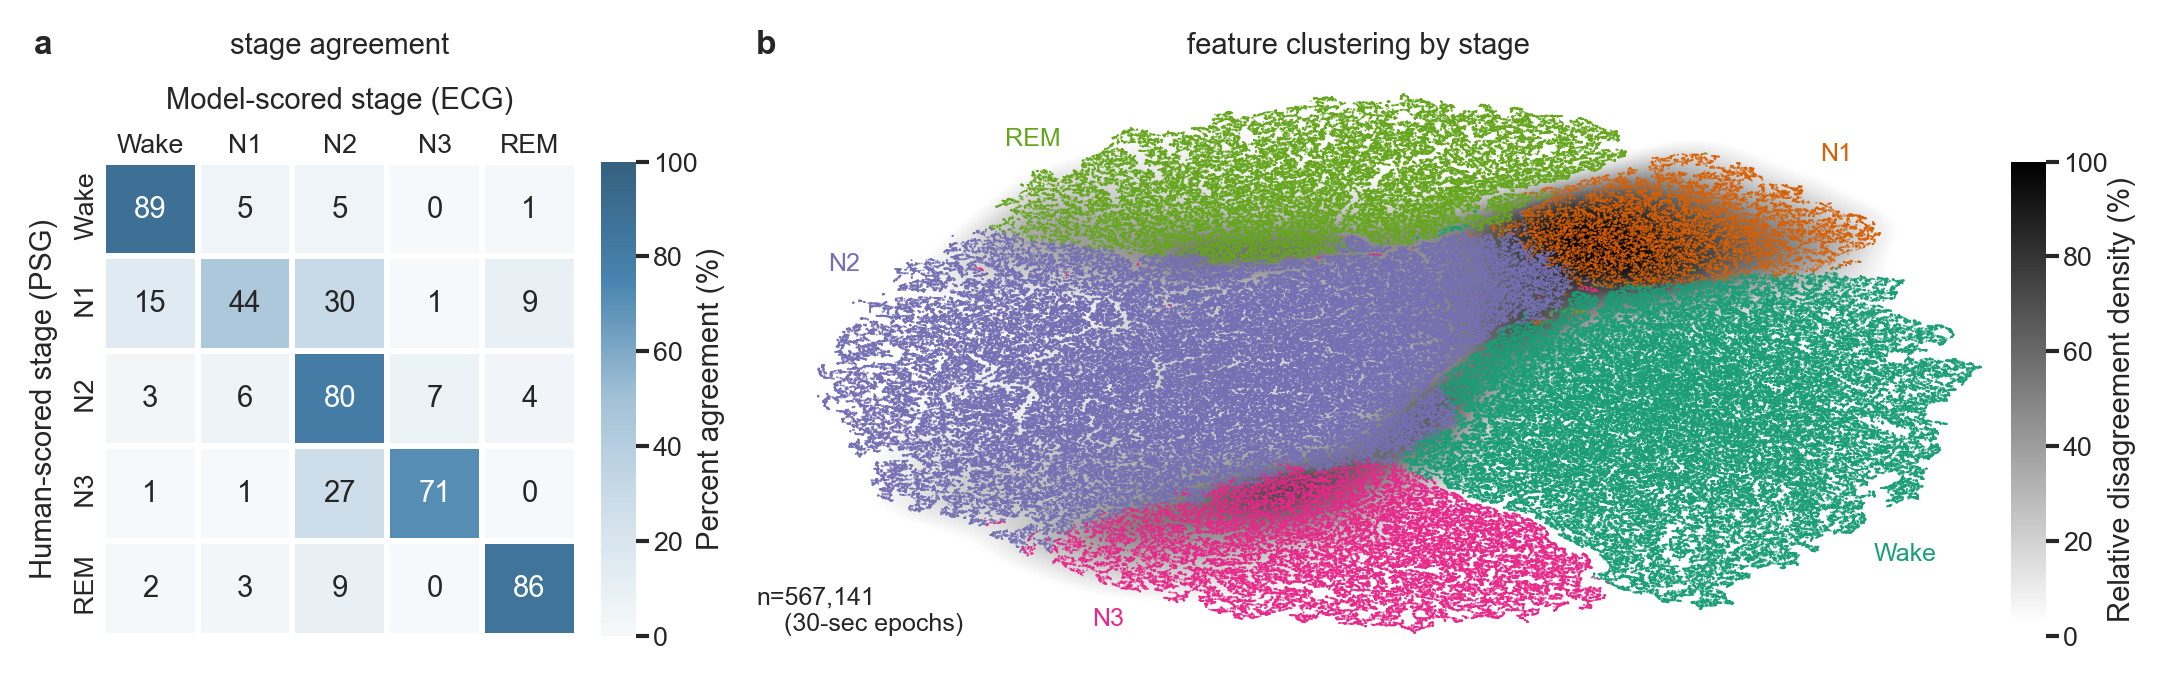

In [14]:
minimal_plot = False  # for just debugging purposes
use_subsample_of_epochs = False  # to speed up the plotting

if use_subsample_of_epochs:
      df_sample = df.sample(frac=0.1, random_state=42)
else:
      df_sample = df


cb_pad = 1
cb_width = 1.5
cb_label = 4

gs = gridspec.GridSpec(2, 8, height_ratios=[1, 6.5], 
                       width_ratios=[20, cb_pad, cb_width, cb_label, 53, cb_pad, cb_width, cb_label])

ax_confusion = plt.subplot(gs[1:, 0])
cb_pad_1 = plt.subplot(gs[1:, 1]) 
cb_1 = plt.subplot(gs[1:, 2])
cb_label_1 = plt.subplot(gs[1:, 3])

ax_tsne = plt.subplot(gs[:, 4])
cb_pad_2 = plt.subplot(gs[1:, 5])
cb_2 = plt.subplot(gs[1:, 6])
cb_label_2 = plt.subplot(gs[1:, 7])


stages = ['Wake','N1','N2','N3','REM']
norm = colors.Normalize(0, 100)


sns.heatmap(accuracy,  annot=True, fmt=".0f", square=True, vmin=0, vmax=100,
            xticklabels=stages, 
            yticklabels=stages,
            cmap=blue_cmap, 
            cbar=False,
            ax=ax_confusion,
            linewidths=1)


ax_confusion.grid(False)

cb_confusion = cb_1.figure.colorbar(cm.ScalarMappable(norm=norm,cmap=blue_cmap), 
             drawedges=False,
             cax=cb_1)

cb_confusion.set_label('Percent agreement (%)', labelpad=0)
cb_confusion.outline.set_visible(False)
cb_confusion.ax.yaxis.set_tick_params(pad=1, length=3)



labelpad = 4
ax_confusion.set_ylabel('Human-scored stage (PSG)', fontweight=None, labelpad=labelpad)
ax_confusion.set_xlabel('Model-scored stage (ECG)', fontweight=None, labelpad=labelpad+2)

ax_confusion.yaxis.set_ticklabels([' '+x for x in stages], fontdict={'verticalalignment': 'center',
                                            'horizontalalignment': 'right'})


ax_confusion.xaxis.set_label_position('top')
ax_confusion.tick_params(labeltop=True, labelbottom=False)

ax_confusion.tick_params(axis='y', width=1, length=0, pad=1, labelrotation=90)
ax_confusion.tick_params(axis='x', width=1, length=0, pad=1)



lowest_percent = 0.025
# create the underlayer first of disagreements
shading_cmap = LinearSegmentedColormap.from_list("custom_grey", [(0, '#FFFFFF'), (lowest_percent, '#FFFFFF'), (1,'#000000')], N=300)


# density plot takes a while
if not minimal_plot:
      sns.kdeplot(x="comp-0", y="comp-1", data=df_sample.loc[~df_sample['match']], 
                  levels=100,
                  thresh=lowest_percent,
                  cmap=shading_cmap,
                  hue_norm=(0, 1),
                  gridsize=300,  #how fine of a grid
                  cut=0,  # truncate curve at end of points
                  fill=True,
                  cbar=False,
                  ax=ax_tsne)

      

dotalpha = 0.7
dotsize = 0.2

# add the agreement dots
for i, stage in enumerate(stage_order):
      if minimal_plot:
            break

      sns.scatterplot(x="comp-0", y="comp-1", data=df_sample.loc[df_sample['match'] & (df_sample['predictions']==stage)], 
            hue="isnan", #"kappa",
            palette=[main_palette[i+1]], #  stage_cmaps[i], 
            # hue_norm=(0, 1), 
            linewidth=0,
            alpha=dotalpha,
            s=dotsize,
            ax=ax_tsne
      )

     

cb_tsne = cb_2.figure.colorbar(cm.ScalarMappable(norm=norm,cmap=shading_cmap), 
            drawedges=False,
            cax=cb_2)
cb_tsne.set_label('Relative disagreement density (%)', labelpad=0)
cb_tsne.outline.set_visible(False)
cb_tsne.ax.yaxis.set_tick_params(pad=1, length=3)


# use labels instead
ax_tsne.legend().remove()


ax_tsne.text(0.91, 0.15, "Wake", transform=ax_tsne.transAxes,
      fontsize=6, va='center', ha='left', color=main_palette[1])

ax_tsne.text(0.88, 0.88, "N1", transform=ax_tsne.transAxes,
      fontsize=6, va='center', ha='center', color=main_palette[2])

ax_tsne.text(0.09, 0.68, "N2", transform=ax_tsne.transAxes,
      fontsize=6, va='center', ha='center', color=main_palette[3])

ax_tsne.text(0.30, 0.01, "N3", transform=ax_tsne.transAxes,
      fontsize=6, va='bottom', ha='center', color=main_palette[4])

ax_tsne.text(0.24, 0.93, "REM", transform=ax_tsne.transAxes,
      fontsize=6, va='top', ha='center', color=main_palette[5])


ax_tsne.grid(False)

ax_tsne.set_ylabel('')
ax_tsne.set_xlabel('')


ax_tsne.set_xlim([df['comp-0'].min()*1.15, df['comp-0'].max()*1.01])
ax_tsne.set_ylim([df['comp-1'].min()*1.01, df['comp-1'].max()*1.02])

ax_tsne.set_xticks([])
ax_tsne.set_yticks([])


blendtransform = blended_transform_factory(ax_confusion.transAxes, ax_tsne.transAxes)

panel_label_y = 1.08
panel_label_x = -0.125
panel_fontsize = 8
ax_confusion.text(panel_label_x, panel_label_y, 'a', transform=blendtransform,
      fontsize=panel_fontsize, fontweight='bold', va='center', ha='center')
ax_tsne.text(0.02, panel_label_y, 'b', transform=ax_tsne.transAxes,
      fontsize=panel_fontsize, fontweight='bold', va='center', ha='left')

panel_title_x = 0.5
title_fontsize = 7
ax_confusion.text(panel_title_x, panel_label_y, 'stage agreement', 
                  transform=blendtransform,
            fontsize=title_fontsize, fontweight=None, va='center', ha='center')
ax_tsne.text(panel_title_x, panel_label_y, 'feature clustering by stage', transform=ax_tsne.transAxes,
      fontsize=title_fontsize, fontweight=None, va='center', ha='center')

# n label
ax_tsne.text(0.02, 0.0, 'n=567,141\n    (30-sec epochs)', transform=ax_tsne.transAxes,
      fontsize=6, va='bottom', ha='left')


# make everything visible for adjustments
if False: #minimal_plot:
      sns.despine(ax=ax_confusion, right=False, top=False, bottom=False, left=False)
      sns.despine(ax=cb_pad_1, right=False, top=False, bottom=False, left=False)
      sns.despine(ax=cb_pad_2, right=False, top=False, bottom=False, left=False)
else:
      sns.despine(ax=ax_tsne, right=True, top=True, bottom=True, left=True)
      sns.despine(ax=cb_label_1, right=True, top=True, bottom=True, left=True)
      sns.despine(ax=cb_label_2, right=True, top=True, bottom=True, left=True)
      sns.despine(ax=cb_pad_1, right=True, top=True, bottom=True, left=True)
      sns.despine(ax=cb_pad_2, right=True, top=True, bottom=True, left=True)

# always keep these hidden
for axes in [cb_pad_1, cb_pad_2, cb_label_1, cb_label_2]:      
      axes.grid(False)
      axes.patch.set_alpha(0)
      axes.set_xticks([])
      axes.set_yticks([])


plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
figure_standard.scale_figure_by_axes(ax_confusion, 1.58, 1.58)

# save the figure
filename = os.path.basename(globals()["__vsc_ipynb_file__"]).replace(".ipynb", "")
figure_standard.save_figure_files(filename, pdf_transparent=False)

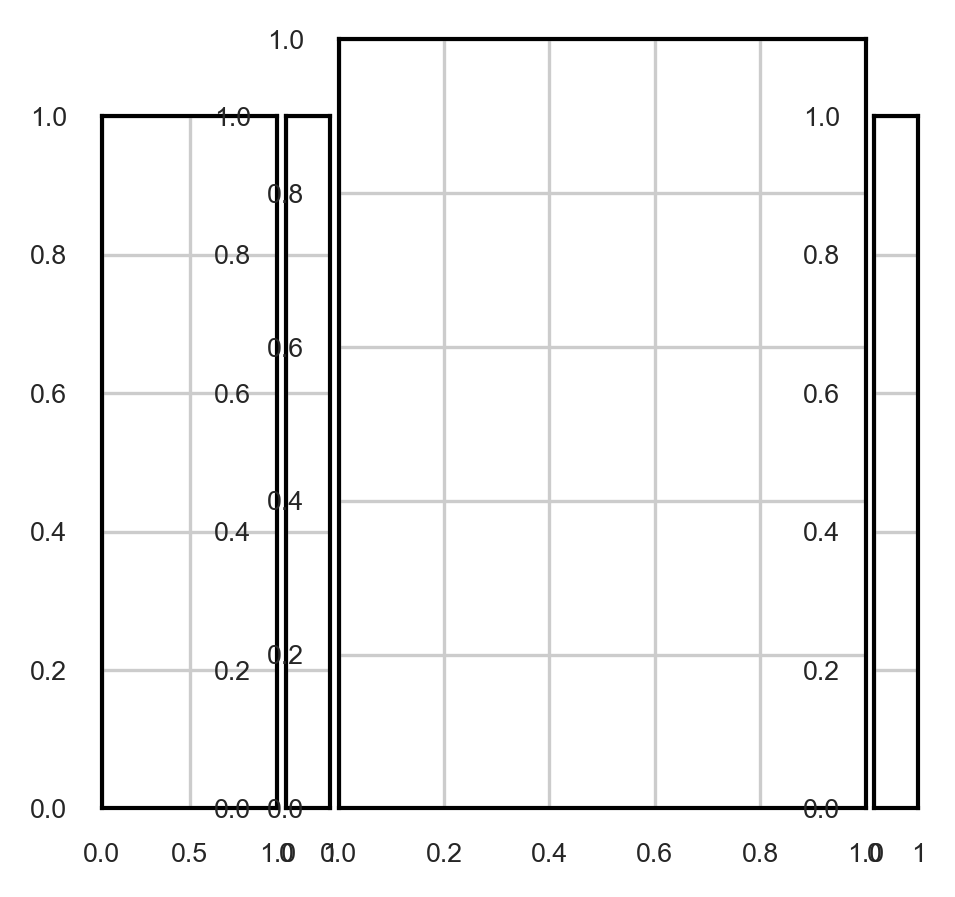

In [15]:
# just for testing layouts

gs = gridspec.GridSpec(2, 8, height_ratios=[1, 9], width_ratios=[20, 1, 5, 1, 60, 1, 5, 1])

ax_confusion = plt.subplot(gs[1:, 0])
cb_1 = plt.subplot(gs[1:, 2])
ax_tsne = plt.subplot(gs[:, 4])
cb_2 = plt.subplot(gs[1:, 6])

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)